## Importing Packages

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np #for getting maximum
import statsmodels.api as sm  #Linear Regression- OLS
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import random #sampling

## Load in our data from objective 1 and original data

In [2]:
PATH = "D:/case studies/syngenta_crop_challenge/Crop Challenge Data_2/Dataset/"

obj1 = pd.read_csv(PATH + 'Objectve1.csv', low_memory=False)

performance = pd.read_csv(PATH + 'performance_data.csv', low_memory=False)

In [3]:
obj1.head(1)

,ENV_ID,ENV_YIELD_MEAN,tavg,TMAX,TMIN,warmnights,hotdays,VP,ELEVATION,dayl_srad_tavg,...,euc0,euc1,hd_stress,heat_drought_stress,heat_stress1,drought_stress1,heat_drought_stress1,heat_stress_s,drought_stress_s,heat_drought_stress_s
0,Env_1,101.42998,11.689227,17.381215,5.997238,0,0,188400,870.65,37545216392,...,0.0,83.519656,83.519656,731.320213,0.0,87.357932,731.320213,0.0,1.0,0.003858


In [4]:
performance.head(1)

,HYBRID_ID,ENV_ID,HYBRID_MG,ENV_MG,YIELD,YEAR,LAT,LONG,PLANT_DATE,HARVEST_DATE,...,ENV_YIELD_STD,ELEVATION,CLAY,SILT,SAND,AWC,PH,OM,CEC,KSAT
0,H2136,Env_94,0,2,135.2951,2012,45.9,-95.1,5/11/2012,9/27/2012,...,14.815002,1312.3,22.75,33.6,43.425,21.6875,6.8,6.9,27.0,4.525


## Joining the Dataset to get stress, Yield and Hybrid-ID

In [5]:
#joining data
df_raw = pd.merge(performance[['HYBRID_ID','ENV_ID','YIELD']],
                 obj1[['ENV_ID','ENV_YIELD_MEAN','heat_stress_s','drought_stress_s','heat_drought_stress_s']],
                 on = 'ENV_ID', 
                 how = 'left')

In [6]:
def display_all(df):
    """ To display more columns than default
    """
    
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [7]:
display_all(df_raw.tail().T)

,387422,387423,387424,387425,387426
HYBRID_ID,H1531,H1037,H1871,H1037,H1531
ENV_ID,Env_557,Env_557,Env_557,Env_557,Env_557
YIELD,100.326,97.9654,134.394,114.827,117.089
ENV_YIELD_MEAN,111.692,111.692,111.692,111.692,111.692
heat_stress_s,0.493695,0.493695,0.493695,0.493695,0.493695
drought_stress_s,0.185209,0.185209,0.185209,0.185209,0.185209
heat_drought_stress_s,0.039241,0.039241,0.039241,0.039241,0.039241


In [8]:
# Standardized Yield within each Hybrid type

df_raw['perc_reduction'] = df_raw.groupby('HYBRID_ID')['YIELD'].transform(lambda x: (np.max(x)-x)/np.max(x))

In [9]:
# Example

df_raw[df_raw.HYBRID_ID == "H2136"].head()

,HYBRID_ID,ENV_ID,YIELD,ENV_YIELD_MEAN,heat_stress_s,drought_stress_s,heat_drought_stress_s,perc_reduction
0,H2136,Env_94,135.2951,124.764197,0.182954,0.984023,0.211190,0.000000
3,H2136,Env_94,125.5679,124.764197,0.182954,0.984023,0.211190,0.071896
11560,H2136,Env_187,124.7918,136.774472,0.122208,0.959172,0.139336,0.077633
11594,H2136,Env_104,124.0943,98.986643,0.155073,0.986805,0.180386,0.082788
15152,H2136,Env_171,123.8382,124.870882,0.164045,0.985460,0.190489,0.084681


In [10]:
def ols_res_coef(df, xcols,  ycol):
    """" Get beta values from Linear regression without the intercept
    """
    X_train=df[xcols]
    y_train=df[ycol]
    x_train = sm.add_constant(X_train)
    est=  smf.OLS(y_train, x_train).fit()
    return est.params[1]

In [11]:
def ols_res_p(df, xcols,  ycol):
    """" Get p-values from Linear regression without the intercept
    """
    X_train=df[xcols]
    y_train=df[ycol]
    x_train = sm.add_constant(X_train)
    est=  smf.OLS(y_train, x_train).fit()
    return est.pvalues[1]


## Stress Resistance check using Linear Regression

In [12]:
def is_resistant(df,stress_metric):
    """ Fetches beta and p value from linear regression model for each Hybrid Type
    to find which Hybrid is resistant to the corresponding stress metric
    Method = Hybrid is non-stress resistant if beta > 0 with more than 90% p value significance
    """
    # Fitting Linear Regression to fetch beta and p value
    
    # Coefficient
    with_heat_coef = pd.DataFrame(df.groupby('HYBRID_ID').apply(ols_res_coef, xcols=[stress_metric], ycol='perc_reduction'))
    # p-value for significance
    with_heat_p_value = pd.DataFrame(df.groupby('HYBRID_ID').apply(ols_res_p, xcols=[stress_metric], ycol='perc_reduction'))
    
    # Joining betas and p values to our original data frame
    
    df = pd.merge(df,
                 with_heat_coef,
                 on = 'HYBRID_ID', 
                 how = 'left')
    df = pd.merge(df ,
                 with_heat_p_value,
                 on='HYBRID_ID', 
                 how='left')
    
    # renaming column names
    df.rename(columns = {"0_x": stress_metric + "_coef", 
                                  "0_y":stress_metric + "_p_value"}, inplace = True)
    
    # Creates stress resitance binary metric 
    df[stress_metric+'_resistant'] = np.where( (df[stress_metric + "_coef"] > 0) & (df[stress_metric + "_p_value"] <= 0.1), 0 , 1)
    
    return(df)

### Stress metric - Heat

In [13]:
df_raw = is_resistant(df_raw,'heat_stress_s')
df_raw.head(1)

,HYBRID_ID,ENV_ID,YIELD,ENV_YIELD_MEAN,heat_stress_s,drought_stress_s,heat_drought_stress_s,perc_reduction,heat_stress_s_coef,heat_stress_s_p_value,heat_stress_s_resistant
0,H2136,Env_94,135.2951,124.764197,0.182954,0.984023,0.21119,0.0,-0.891224,0.003062,1


### Stress metric - Drought

In [14]:
df_raw = is_resistant(df_raw,'drought_stress_s')
df_raw.head(1)

,HYBRID_ID,ENV_ID,YIELD,ENV_YIELD_MEAN,heat_stress_s,drought_stress_s,heat_drought_stress_s,perc_reduction,heat_stress_s_coef,heat_stress_s_p_value,heat_stress_s_resistant,drought_stress_s_coef,drought_stress_s_p_value,drought_stress_s_resistant
0,H2136,Env_94,135.2951,124.764197,0.182954,0.984023,0.21119,0.0,-0.891224,0.003062,1,0.125524,0.389089,1


### Stress metric - Heat and Drought

In [15]:
df_raw = is_resistant(df_raw,'heat_drought_stress_s')
df_raw.head(1)

,HYBRID_ID,ENV_ID,YIELD,ENV_YIELD_MEAN,heat_stress_s,drought_stress_s,heat_drought_stress_s,perc_reduction,heat_stress_s_coef,heat_stress_s_p_value,heat_stress_s_resistant,drought_stress_s_coef,drought_stress_s_p_value,drought_stress_s_resistant,heat_drought_stress_s_coef,heat_drought_stress_s_p_value,heat_drought_stress_s_resistant
0,H2136,Env_94,135.2951,124.764197,0.182954,0.984023,0.21119,0.0,-0.891224,0.003062,1,0.125524,0.389089,1,-0.613757,0.015539,1


In [16]:
display_all(df_raw.tail().T)

,387422,387423,387424,387425,387426
HYBRID_ID,H1531,H1037,H1871,H1037,H1531
ENV_ID,Env_557,Env_557,Env_557,Env_557,Env_557
YIELD,100.326,97.9654,134.394,114.827,117.089
ENV_YIELD_MEAN,111.692,111.692,111.692,111.692,111.692
heat_stress_s,0.493695,0.493695,0.493695,0.493695,0.493695
drought_stress_s,0.185209,0.185209,0.185209,0.185209,0.185209
heat_drought_stress_s,0.039241,0.039241,0.039241,0.039241,0.039241
perc_reduction,0.452991,0.523091,0.339892,0.441008,0.361597
heat_stress_s_coef,0.0735477,0.268918,-0.207998,0.268918,0.0735477
heat_stress_s_p_value,9.31648e-05,0,1.20587e-19,0,9.31648e-05


## Visualization

In [17]:
plt.rcParams['figure.figsize'] = [20, 5]

### Heat

Text(0.5,1,'Heat susceptible Hybrids')

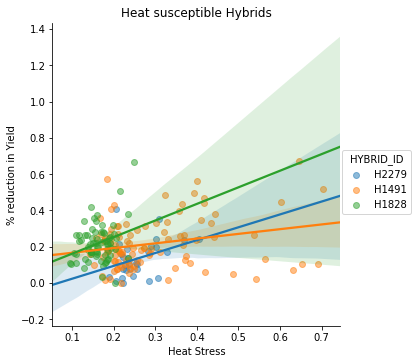

In [18]:
# Non - Heat Resistant hybrids vs Heat stress
# sampling 3 Hybrids - as can't show all in same plot

hybrids = list(set(df_raw.HYBRID_ID[df_raw.heat_stress_s_resistant==0]))
# In-place shuffle
random.shuffle(hybrids) 
sample=df_raw[(df_raw.HYBRID_ID.isin(hybrids[0:3]))]

sns.lmplot( x="heat_stress_s", y="perc_reduction", data=sample, fit_reg=True, hue='HYBRID_ID', legend=True,scatter_kws={"alpha":0.5})
plt.xlabel('Heat Stress')
plt.ylabel('% reduction in Yield')
plt.title('Heat susceptible Hybrids')

### Drought

Text(0.5,1,'Drought susceptible Hybrids')

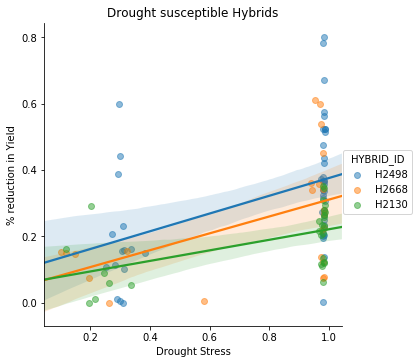

In [20]:
# Non - Drought Resistant hybrids vs Drought stress
# sampling 3 Hybrids - as can't show all in same plot

hybrids = list(set(df_raw.HYBRID_ID[df_raw.heat_drought_stress_s_resistant==0]))
# In-place shuffle
random.shuffle(hybrids) 
sample=df_raw[(df_raw.HYBRID_ID.isin(hybrids[0:3]))]

sns.lmplot( x="drought_stress_s", y="perc_reduction", data=sample, fit_reg=True, hue='HYBRID_ID', legend=True,scatter_kws={"alpha":0.5})
plt.xlabel('Drought Stress')
plt.ylabel('% reduction in Yield')
plt.title('Drought susceptible Hybrids')


### Heat and Drought

Text(0.5,1,'Heat & Drought susceptible Hybrids')

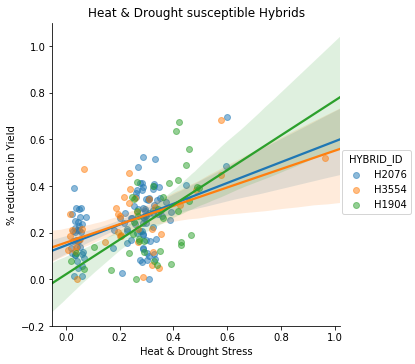

In [21]:
# Non - Heat & Drought Resistant hybrids vs Heat & Drought stress
# sampling 3 Hybrids - as can't show all in same plot

hybrids = list(set(df_raw.HYBRID_ID[df_raw.drought_stress_s_resistant==0]))
# In-place shuffle
random.shuffle(hybrids) 
sample=df_raw[(df_raw.HYBRID_ID.isin(hybrids[0:3]))]

sns.lmplot( x="heat_drought_stress_s", y="perc_reduction", data=sample, fit_reg=True, hue='HYBRID_ID', legend=True,scatter_kws={"alpha":0.5})
plt.xlabel('Heat & Drought Stress')
plt.ylabel('% reduction in Yield')
plt.title('Heat & Drought susceptible Hybrids')


In [36]:
df_raw.to_csv("hybridresistance.csv", index=False) 